In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install -U object-detection-fastai

     |████████████████████████████████| 51.0MB 62kB/s 
     |████████████████████████████████| 317kB 38.3MB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=27673 sha256=f0ec3a1986cf63feee393778c91d5cbca0fbf586dc883eaae395a4d3f5e616c9
  Stored in directory: /root/.cache/pip/wheels/6b/55/74/ba9d3dcc2c5c0f1282e08bae70df0ed57b496fb6b5c8f1adc9
Successfully built openslide-python
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [7]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [8]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [ ]:
coco = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = 'images/grizzly.jpg'


In [6]:
coco = untar_data("https://github.com/wargreymon89/ObjectDetection/raw/master/data/cars", force_download=True)
images, lbl_bbox = get_annotations(coco/'annotations/train_sample.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

A new version of the dataset is available.


In [ ]:
coco

PosixPath('/root/.fastai/data/cars')

In [9]:
size = 1024

In [10]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(tfm_y=True ,size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=2, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate
#data = data.normalize()

In [ ]:
data

ImageDataBunch;

Train: LabelList (7 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (3024, 4032),ImageBBox (3024, 4032),ImageBBox (3024, 4032),ImageBBox (3024, 4032),ImageBBox (3024, 4032)
Path: /root/.fastai/data/cars;

Valid: LabelList (1 items)
x: ObjectItemList
Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (3024, 4032)
Path: /root/.fastai/data/cars;

Test: None

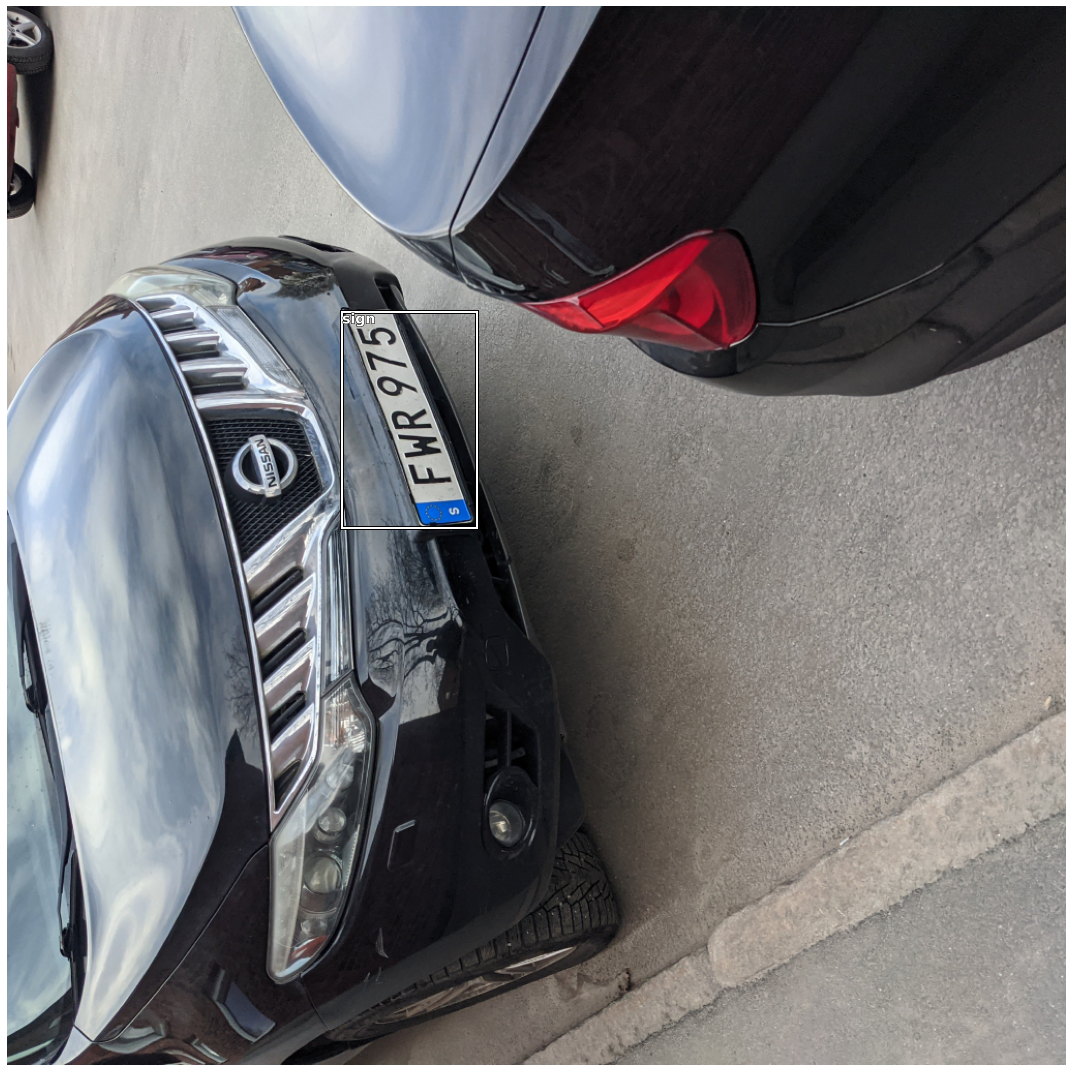

In [11]:
data.show_batch(rows=1, ds_type=DatasetType.Valid, figsize=(15,15))

In [ ]:
data.classes

['background', 'sign']

In [ ]:
[1,2**(1/3), 2**(2/3)]

[1, 1.2599210498948732, 1.5874010519681994]

In [12]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.25, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [13]:
len(anchors)

24480

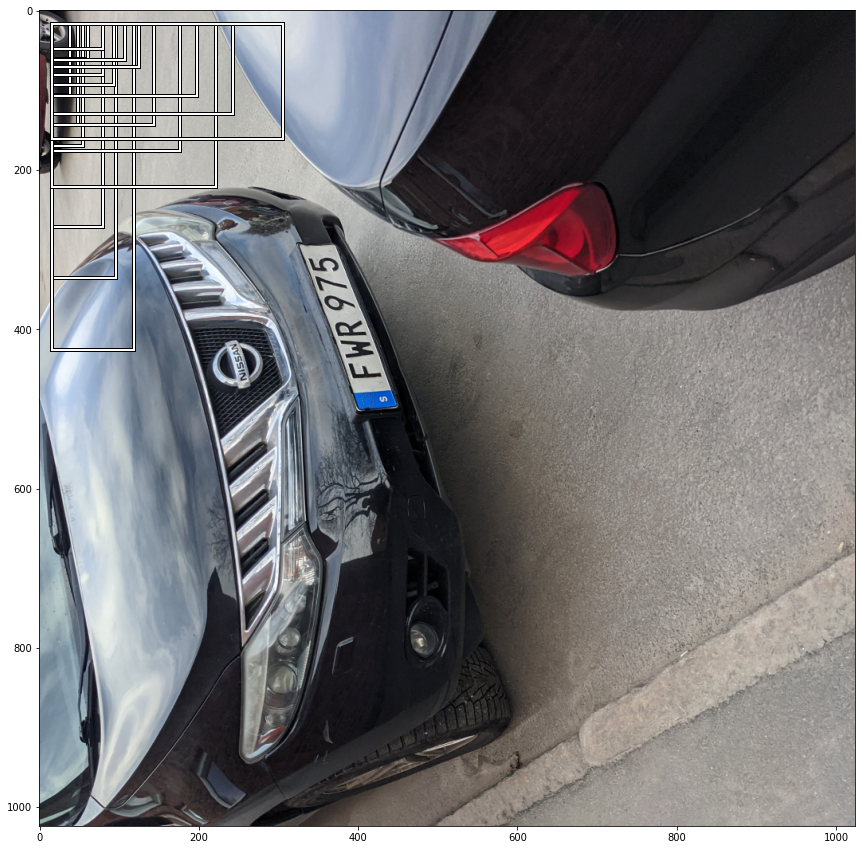

In [14]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

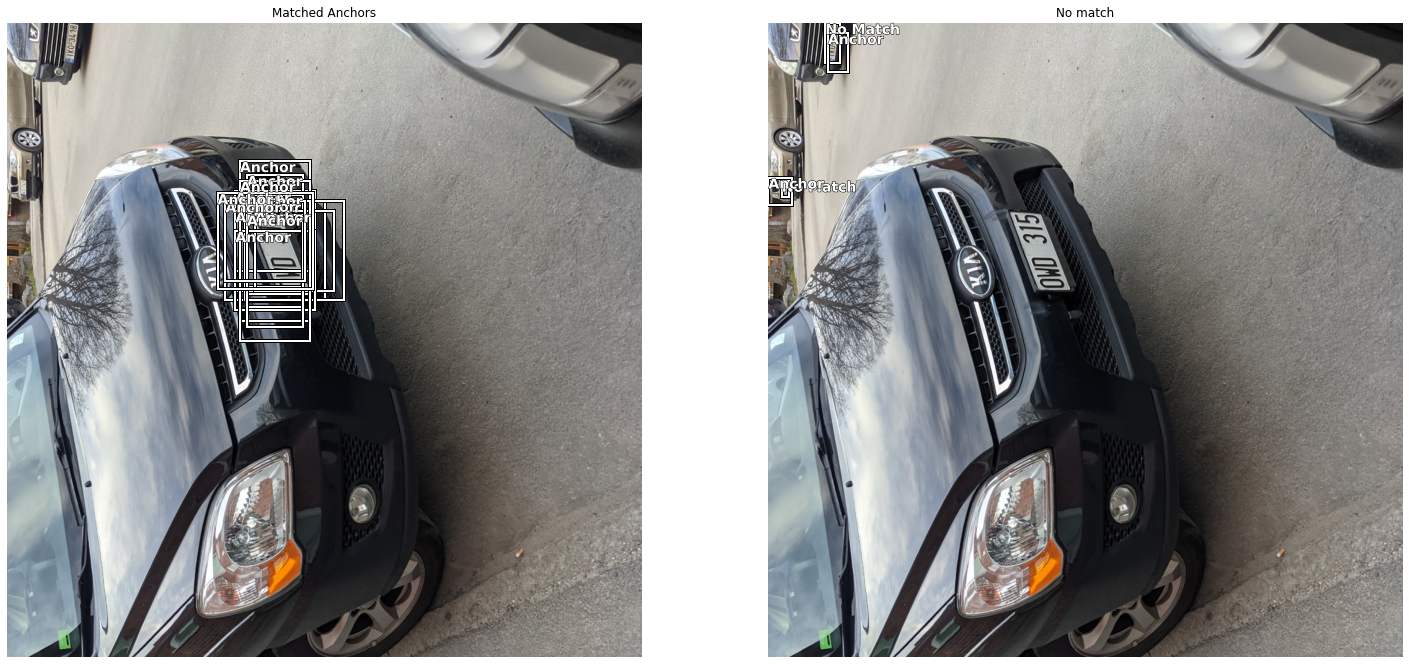

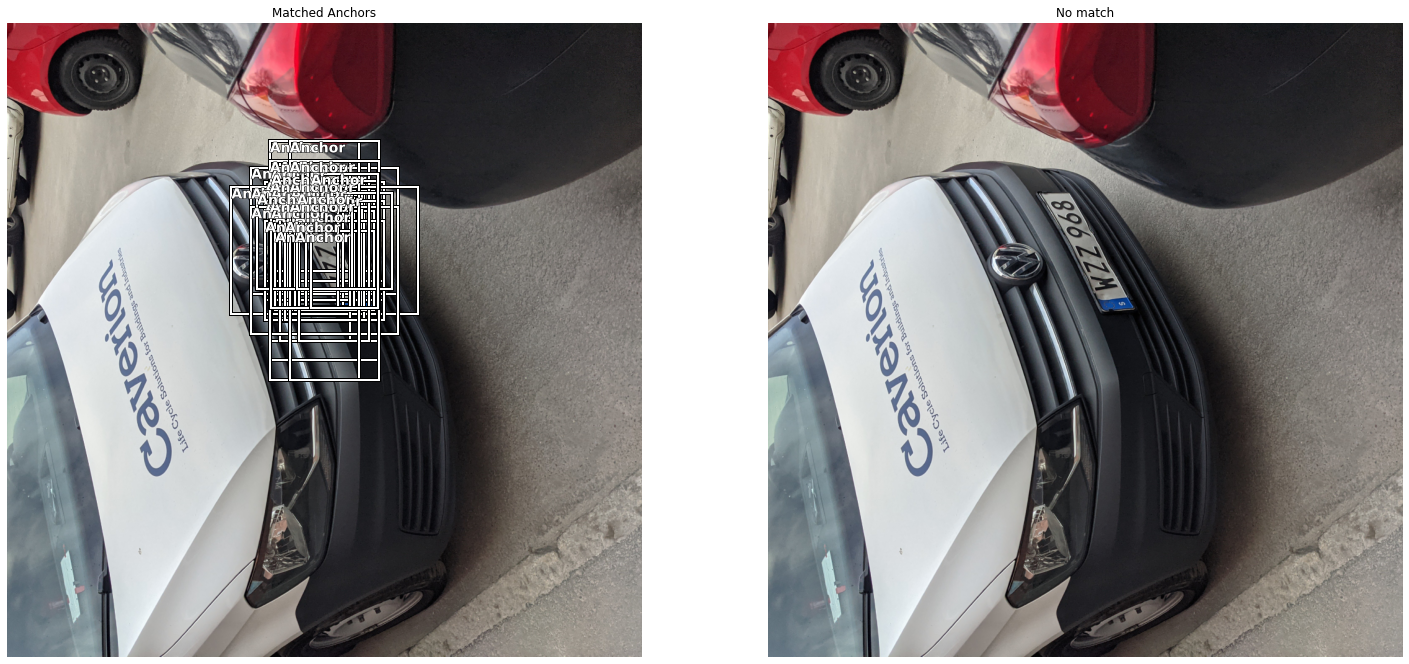

In [15]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

In [16]:
data.train_ds.c

2

In [17]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)
#model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [18]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [19]:
learn.split([model.encoder[2], model.c5top5])
learn.freeze_to(-2)

In [ ]:
self.

In [20]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


IndexError: ignored

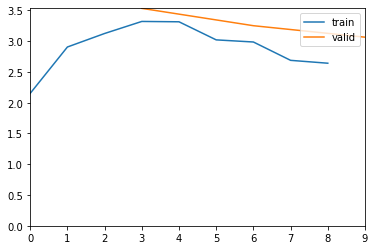

In [ ]:
learn.fit_one_cycle(3, 2e-4)

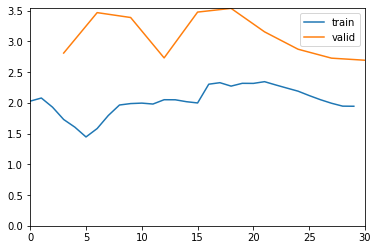

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

In [ ]:
data.train_ds.classes

['background', 'sign']

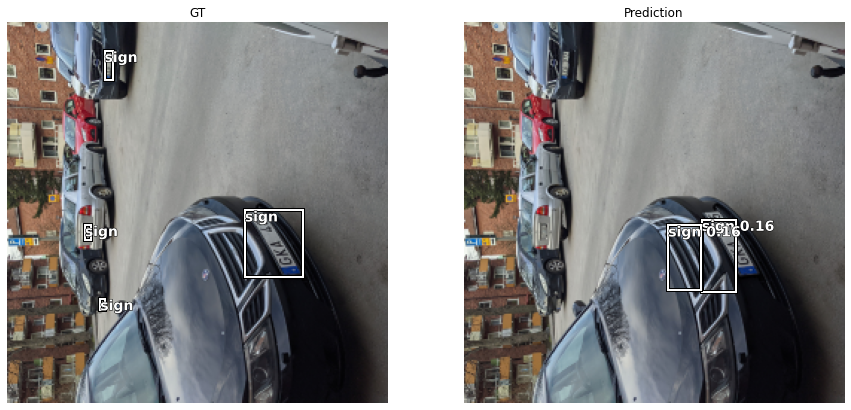

In [ ]:
show_results_side_by_side(learn, anchors, detect_thresh=0.15, nms_thresh=0.1, image_count=25)